In [3]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import os
from scipy import misc
import argparse
import sys
# Will use matplotlib for showing the image
from matplotlib import pyplot as plt

In [4]:
g_mean = np.array(([126.88,120.24,112.19])).reshape([1,1,3])
output_folder = "./test_output"

In [5]:
def rgba2rgb(img):
    return img[:,:,:3]*np.expand_dims(img[:,:,3],2)

In [59]:
def refine_images():
    
    if not os.path.exists('./enhanced'):
        os.mkdir('./enhanced')
    
    input_image_filenames = glob.glob("../sketchy_database/256x256/photo/tx_000100000000/zebra/*.jpg")
    for filename in input_image_filenames:
        
        image = cv2.imread(filename, cv2.IMREAD_COLOR)
    
        image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # equalize the histogram of the Y channel
        image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
        output_image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
        
        input_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
        plt.imshow(np.hstack((input_rgb,output_rgb)))
        
        
        filename_without_path = filename[56:]
        print(filename_without_path)
        
        cv2.imwrite('./enhanced/' + filename_without_path, output_image)

n02391049_9719.jpg
n02391049_10132.jpg
n02391049_8321.jpg
n02391049_8445.jpg
n02391049_3232.jpg
n02391049_9918.jpg
n02391049_3770.jpg
n02391049_4903.jpg
n02391049_3947.jpg
n02391049_8951.jpg
n02391049_9137.jpg
n02391049_8000.jpg
n02391049_6860.jpg
n02391049_2136.jpg
n02391049_10175.jpg
n02391049_4069.jpg
n02391049_6993.jpg
n02391049_2853.jpg
n02391049_1551.jpg
n02391049_4814.jpg
n02391049_712.jpg
n02391049_9193.jpg
n02391049_4474.jpg
n02391049_944.jpg
n02391049_1159.jpg
n02391049_1121.jpg
n02391049_8696.jpg
n02391049_415.jpg
n02391049_9822.jpg
n02391049_7851.jpg
n02391049_5189.jpg
n02391049_7886.jpg
n02391049_9400.jpg
n02391049_2905.jpg
n02391049_1118.jpg
n02391049_8266.jpg
n02391049_7018.jpg
n02391049_2366.jpg
n02391049_2559.jpg
n02391049_3162.jpg
n02391049_1526.jpg
n02391049_1024.jpg
n02391049_2146.jpg
n02391049_1516.jpg
n02391049_857.jpg
n02391049_316.jpg
n02391049_3333.jpg
n02391049_403.jpg
n02391049_9960.jpg
n02391049_3239.jpg
n02391049_1211.jpg
n02391049_2696.jpg
n02391049_2852.j

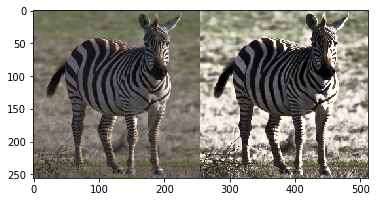

In [60]:
refine_images()

In [61]:
def generate_salience_maps():
    
    rgb_folder = "./enhanced"
    gpu_fraction = 1.0
    
    if not os.path.exists('./salience_maps'):
        os.mkdir('./salience_maps')
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = gpu_fraction)
    with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
        saver = tf.train.import_meta_graph('./meta_graph/my-model.meta')
        saver.restore(sess,tf.train.latest_checkpoint('./salience_model'))
        image_batch = tf.get_collection('image_batch')[0]
        pred_mattes = tf.get_collection('mask')[0]

        
        rgb_pths = os.listdir(rgb_folder)
        for rgb_pth in rgb_pths:
            rgb = misc.imread(os.path.join(rgb_folder,rgb_pth))
            if rgb.shape[2]==4:
                rgb = rgba2rgb(rgb)
            origin_shape = rgb.shape
            rgb = np.expand_dims(misc.imresize(rgb.astype(np.uint8),[320,320,3],interp="nearest").astype(np.float32)-g_mean,0)

            feed_dict = {image_batch:rgb}
            pred_alpha = sess.run(pred_mattes,feed_dict = feed_dict)
            final_alpha = misc.imresize(np.squeeze(pred_alpha),origin_shape)
            misc.imsave(os.path.join('./salience_maps',rgb_pth),final_alpha)


In [62]:
generate_salience_maps()

INFO:tensorflow:Restoring parameters from ./salience_model/model.ckpt-200


/home/leytonblackler/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/leytonblackler/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/leytonblackler/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/leytonblackler/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [63]:
def convert_salience_maps_to_binary_masks():
    
    if not os.path.exists('./binary_masks'):
        os.mkdir('./binary_masks')
    
    input_image_filenames = glob.glob("./salience_maps/*.jpg")
    for filename in input_image_filenames:
        
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
        (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        before = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        after = cv2.cvtColor(im_bw,cv2.COLOR_GRAY2RGB)
        plt.imshow(np.hstack((before,after)))
        
        filename_without_path = filename[16:]
        print(filename_without_path)
        
        cv2.imwrite('./binary_masks/' + filename_without_path, im_bw)

n02391049_9719.jpg
n02391049_10132.jpg
n02391049_8321.jpg
n02391049_8445.jpg
n02391049_3232.jpg
n02391049_9918.jpg
n02391049_3770.jpg
n02391049_4903.jpg
n02391049_3947.jpg
n02391049_8951.jpg
n02391049_9137.jpg
n02391049_8000.jpg
n02391049_6860.jpg
n02391049_2136.jpg
n02391049_10175.jpg
n02391049_4069.jpg
n02391049_6993.jpg
n02391049_2853.jpg
n02391049_1551.jpg
n02391049_4814.jpg
n02391049_712.jpg
n02391049_9193.jpg
n02391049_4474.jpg
n02391049_944.jpg
n02391049_1159.jpg
n02391049_1121.jpg
n02391049_8696.jpg
n02391049_415.jpg
n02391049_9822.jpg
n02391049_7851.jpg
n02391049_5189.jpg
n02391049_7886.jpg
n02391049_9400.jpg
n02391049_2905.jpg
n02391049_1118.jpg
n02391049_8266.jpg
n02391049_7018.jpg
n02391049_2366.jpg
n02391049_2559.jpg
n02391049_3162.jpg
n02391049_1526.jpg
n02391049_1024.jpg
n02391049_2146.jpg
n02391049_1516.jpg
n02391049_857.jpg
n02391049_316.jpg
n02391049_3333.jpg
n02391049_403.jpg
n02391049_9960.jpg
n02391049_3239.jpg
n02391049_1211.jpg
n02391049_2696.jpg
n02391049_2852.j

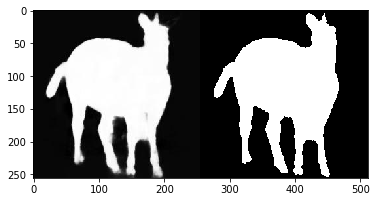

In [64]:
convert_salience_maps_to_binary_masks()

In [69]:
def apply_binary_mask_to_original_images():
    
    if not os.path.exists('./extracted'):
        os.mkdir('./extracted')
    
    mask_filenames = glob.glob("./binary_masks/*.jpg")
    for filename in mask_filenames:
        
        mask = cv2.imread(filename, cv2.IMREAD_COLOR)
        filename_without_path = filename[15:]
        original = cv2.imread('../sketchy_database/256x256/photo/tx_000100000000/zebra/' + filename_without_path, cv2.IMREAD_COLOR)
        
        extracted = cv2.bitwise_and(original, mask)
        
        #inverted_mask = cv2.bitwise_not(mask)
        
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original_and_mask = np.hstack((original_rgb, mask))
        extracted_rgb = cv2.cvtColor(extracted, cv2.COLOR_BGR2RGB)
        original_and_mask_and_extracted = np.hstack((original_and_mask, extracted_rgb))
        plt.imshow(original_and_mask_and_extracted)
        
        cv2.imwrite('./extracted/' + filename_without_path, extracted)

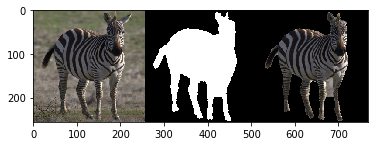

In [70]:
apply_binary_mask_to_original_images()